In [1]:
import pandas as pd
import glob
import csv
import numpy as np
from collections import Counter
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import time
import cv2
import copy
from tqdm.auto import tqdm
import h5py
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# For NVIDIA

In [3]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

device(type='cuda', index=0)

# For AMD

In [ ]:
# no need to run
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

class_name = [classes[x] for x in classes]

In [5]:
#no need to run
def verify(img, cls_id):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print(classes[cls_id])

In [6]:
torch.manual_seed(123)

# Transformation

In [7]:
train_trasform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = 299),
        # transforms.RandomResizedCrop(299),
        # transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees = 15),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_and_val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = 299),
        # transforms.CenterCrop(299),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Loading train, test and validation image

**Copying data to local runtime**

In [ ]:
!cp -r /content/drive/MyDrive/Softcom_Dataset/test_data.hdf5 /content/sample_data
!cp -r /content/drive/MyDrive/Softcom_Dataset/train_data.hdf5 /content/sample_data
!cp -r /content/drive/MyDrive/Softcom_Dataset/validation_data.hdf5 /content/sample_data

# For Tanim

In [ ]:
train_dataset_path = 'G:/Jupyter/Train'
test_dataset_path = 'G:/Jupyter/Test'
validation_dataset_path = 'G:/Jupyter/Valid'

# For Atiq

In [ ]:
train_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/train_data.hdf5"
test_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/test_data.hdf5"
validation_dataset_path = "F:/CSE 4.2/CSE 4138 (Soft Computing Lab)/Dataset/validation_data.hdf5"

# For Colab

In [8]:
train_dataset_path = "/content/drive/MyDrive/Uploaded/Softcom Lab/train_data.hdf5"
test_dataset_path = '/content/drive/MyDrive/Uploaded/Softcom Lab/test_data.hdf5'
validation_dataset_path = "/content/drive/MyDrive/Uploaded/Softcom Lab/validation_data.hdf5"

# Custom Dataloader

In [9]:
class dataset_h5(torch.utils.data.Dataset):
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()
 
        self.file = h5py.File(in_file, 'r')
        self.transform = transform
 
    def __getitem__(self, index):
        x = self.file['images'][index]
        original = self.file['images'][index]
        y = self.file['labels'][index]
        # Preprocessing each image
        if self.transform is not None:
            x = self.transform(x)        
        return x, y, original
 
    def __len__(self):
        return self.file['images'].shape[0]

# Batch the dataset

In [10]:
dataset = dataset_h5(train_dataset_path, transform = train_trasform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=True)

dataset = dataset_h5(test_dataset_path, transform = test_and_val_transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=False)

dataset = dataset_h5(validation_dataset_path, transform = test_and_val_transform)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=8, drop_last=True, shuffle=False)

# Creating the dictionary of train and validation dataset

In [11]:
dataloaders = {"train" : train_loader,
               "val" : validation_loader}

# Model initialize

In [12]:
def create_model():
    model = torchvision.models.inception_v3(pretrained=True)

    # for param in model.parameters():
    #     param.requires_grad = False
    
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs,  43)
    # Handle the primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 43)

    return model.to(dml)

In [13]:
base_model = create_model()
base_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Defining Hyperparameter

In [ ]:
num_classes = 43
num_epochs = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate)

# Training the model

In [ ]:
validation_loss = []
training_loss = []

def train_model():
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(base_model.state_dict())
    best_acc = 0.0
    
    progress_bar_train = tqdm(range(num_epochs * len(train_loader)))
    progress_bar_eval = tqdm(range(num_epochs * len(validation_loader)))
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                base_model.train()  # Set model to training mode
            else:
                base_model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(dml)
                labels = labels.to(dml)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        outputs, aux_outputs = base_model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2

                        loss.backward()
                        optimizer.step()
                        progress_bar_train.update(1)

                    elif phase == 'val':
                        outputs = base_model(inputs)
                        loss = criterion(outputs, labels)
                        progress_bar_eval.update(1)

                    
                    _, preds = torch.max(outputs, 1)
                        
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cpu()
                labels = labels.data.cpu()
                running_corrects += (preds == labels).sum()
            
            print("Lenght: ", len(dataloaders[phase].dataset))
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
              training_loss.append(epoch_loss)
            elif phase == 'val':
              validation_loss.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(base_model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    base_model.load_state_dict(best_model_wts)
    return base_model, val_acc_history

In [ ]:
best_model, validation_acc_hist = train_model()

  0%|          | 0/46650 [00:00<?, ?it/s]

  0%|          | 0/5180 [00:00<?, ?it/s]

Epoch 0/9
----------
Lenght:  37323
train Loss: 0.3065 Acc: 0.9468
Lenght:  4148
val Loss: 0.0271 Acc: 0.9928

Epoch 1/9
----------
Lenght:  37323
train Loss: 0.0523 Acc: 0.9911
Lenght:  4148
val Loss: 0.0095 Acc: 0.9973

Epoch 2/9
----------
Lenght:  37323
train Loss: 0.0334 Acc: 0.9941
Lenght:  4148
val Loss: 0.0079 Acc: 0.9969

Epoch 3/9
----------
Lenght:  37323
train Loss: 0.0290 Acc: 0.9952
Lenght:  4148
val Loss: 0.0087 Acc: 0.9973

Epoch 4/9
----------
Lenght:  37323
train Loss: 0.0260 Acc: 0.9954
Lenght:  4148
val Loss: 0.0079 Acc: 0.9976

Epoch 5/9
----------
Lenght:  37323
train Loss: 0.0189 Acc: 0.9965
Lenght:  4148
val Loss: 0.0035 Acc: 0.9981

Epoch 6/9
----------
Lenght:  37323
train Loss: 0.0219 Acc: 0.9965
Lenght:  4148
val Loss: 0.0024 Acc: 0.9981

Epoch 7/9
----------
Lenght:  37323
train Loss: 0.0122 Acc: 0.9977
Lenght:  4148
val Loss: 0.0101 Acc: 0.9973

Epoch 8/9
----------
Lenght:  37323
train Loss: 0.0181 Acc: 0.9973
Lenght:  4148
val Loss: 0.0068 Acc: 0.9983

E

# Plotting training and validation loss

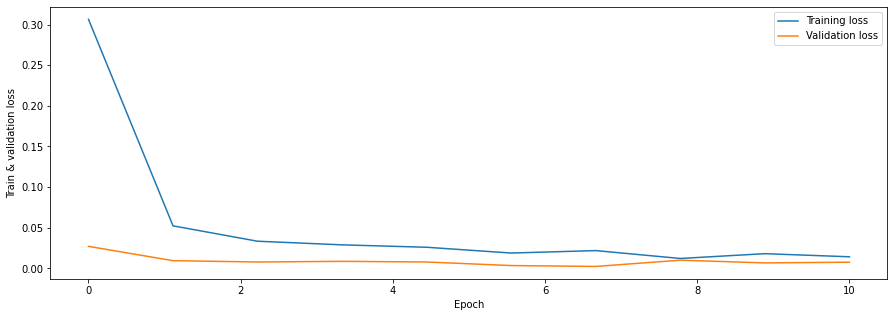

In [ ]:
x = torch.linspace(0, num_epochs, num_epochs)
plt.figure(figsize=(15,5))
plt.plot(x, training_loss)
plt.plot(x, validation_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epoch")
plt.ylabel("Train & validation loss")
plt.show()

# Saving trained model to drive

In [14]:
model_path = '/content/drive/MyDrive/Uploaded/Softcom Lab/Trained models/inceptionv3.pt'

In [ ]:
torch.save(best_model.state_dict(), model_path)

# Run this cell only if you load directly trained model from drive

In [15]:
best_model = base_model

# Loading model from drive

In [16]:
if torch.cuda.is_available():
  best_model.load_state_dict(torch.load(model_path))
else:
  best_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Testing the model using test dataset

In [17]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    best_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []
    
    with torch.no_grad():
        for images, labels, original in test_loader:
            images = images.to(dml)
            labels = labels.to(dml)
            
            outputs = softmax(best_model(images))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append(np.array(original[ind]))
            
    return predictions, real_values, pred_probas, misclassified

In [18]:
pred, real, probas, misclasses = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], target_names = class_name, digits=4))

                               precision    recall  f1-score   support

         Speed limit (20km/h)     1.0000    1.0000    1.0000        54
         Speed limit (30km/h)     1.0000    0.9966    0.9983       588
         Speed limit (50km/h)     0.9967    0.9983    0.9975       600
         Speed limit (60km/h)     0.9973    0.9946    0.9960       372
         Speed limit (70km/h)     0.9981    1.0000    0.9991       528
         Speed limit (80km/h)     0.9960    0.9960    0.9960       498
  End of speed limit (80km/h)     1.0000    1.0000    1.0000       114
        Speed limit (100km/h)     1.0000    1.0000    1.0000       378
        Speed limit (120km/h)     0.9973    1.0000    0.9987       372
                   No passing     1.0000    0.9974    0.9987       390
 No passing veh over 3.5 tons     1.0000    0.9981    0.9991       534
 Right-of-way at intersection     1.0000    1.0000    1.0000       348
                Priority road     1.0000    1.0000    1.0000       558
     

# More details score

In [21]:
def score_in_details():
  y_pred = [y.item() for y in pred]
  y_real = [y.item() for y in real]
    
  temp = []
  for i in probas:
    temp1 = []
    for j in i:
        temp1.append(j.item())
    temp.append(temp1)

  accuracy = recall_score(y_real, y_pred, average='macro')
  precision = precision_score(y_real, y_pred, average='macro')
  recall = recall_score(y_real, y_pred, average='macro')
  f1 = f1_score(y_real, y_pred, average='macro')
  roc_auc = roc_auc_score(y_real, temp, multi_class='ovr')
  mcc_score = matthews_corrcoef(y_real, y_pred);

  print(f"Accuracy: {accuracy * 100}%")
  print(f"Precision: {precision * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1-score: {f1 * 100}%")
  print(f"MCC-score: {mcc_score * 100}%")
  print(f"ROC AUC score: {roc_auc}")
  
  print()
  print()

  conf_matrix = confusion_matrix(y_real, y_pred)
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g', xticklabels=class_name, yticklabels=class_name)
  plt.title('Confusion matrix', fontsize=20)
  plt.ylabel('Actual label', fontsize=20)
  plt.xlabel('Predicted label', fontsize=20)
  plt.show()

Accuracy: 99.92196275879259%
Precision: 99.81961261732476%
Recall: 99.92196275879259%
F1-score: 99.87019192630518%
MCC-score: 99.87985479718068%
ROC AUC score: 0.9999909017578404




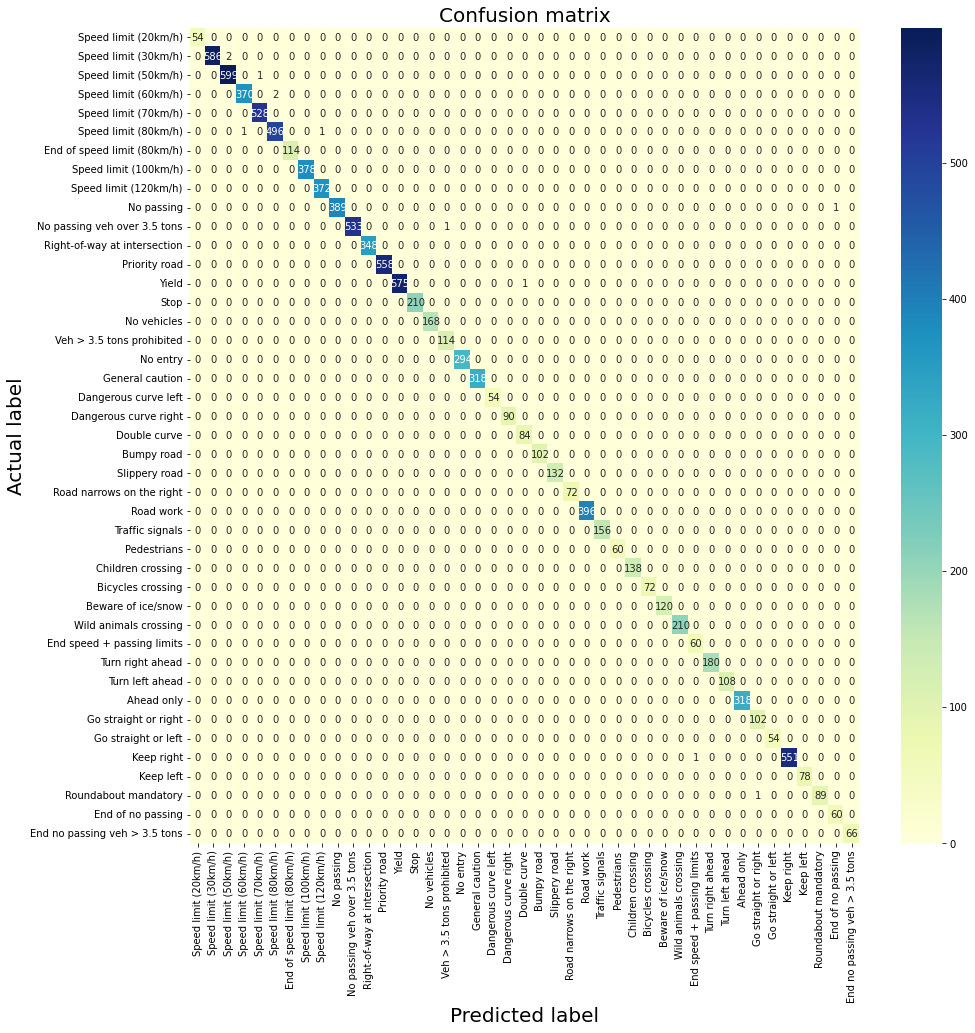

In [22]:
score_in_details()

In [23]:
for no, img in enumerate(misclasses):
    matplotlib.image.imsave(f'/content/drive/MyDrive/Uploaded/Softcom Lab/Images/Inception Misclassified/img_{no + 1}.png', img)